In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')

## Some distributions Eager modes aren't implemented yet
# tf.enable_eager_execution()  ## I think Eager mode makes some errors

# Some warnings come up related to datetime. Suppress them
import warnings
warnings.filterwarnings('ignore')

tf.set_random_seed(42)

C:\Users\james\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\james\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\james\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\james\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\james\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, 

In [2]:
tfp

<module 'tensorflow_probability' from 'C:\\Users\\james\\Anaconda3\\lib\\site-packages\\tensorflow_probability\\__init__.py'>

Text(0.5,1,'Text counts per day')

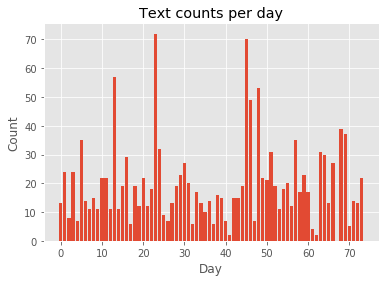

In [3]:
data = pd.read_csv('data/txtdata.csv', header=None)
data = np.squeeze(data.values).astype(np.float32)
n_data = len(data)
plt.bar(x=np.arange(n_data), height=data)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Text counts per day')

In [4]:
alpha0 = float(1./data.mean())

In [5]:
def model():
    lambda1 = tfp.edward2.Exponential(name='lambda1', rate=alpha0)
    lambda2 = tfp.edward2.Exponential(name='lambda2', rate=alpha0)

    tau = tfp.edward2.Uniform(name='tau', low=0., high=float(n_data))

    idx = np.arange(int(n_data))
    lambda_ = tf.where(name='lambda_', condition=tau > idx, 
                       x=tf.ones(shape=[n_data], dtype=tf.float32)*lambda1, 
                       y=tf.ones(shape=[n_data], dtype=tf.float32)*lambda2)
    
    observed = tfp.edward2.Poisson(name='observed', rate=lambda_)
    return observed

In [6]:
log_joint = tfp.edward2.make_log_joint_fn(model)
def target_log_prob_fn(lambda1, lambda2, tau):
    return log_joint(
        lambda1=lambda1,
        lambda2=lambda2,
        tau=tau,
        observed=data)

In [7]:
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=5000,
    num_burnin_steps=150,
    current_state=[
        tfp.edward2.Exponential(name='qlambda1', rate=alpha0),
        tfp.edward2.Exponential(name='qlambda2', rate=alpha0),
        tfp.edward2.Uniform(name='qTau', low=0., high=float(n_data))],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        step_size=0.1,
        num_leapfrog_steps=3))

lambda1, lambda2, tau = states

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    lambda1_, lambda2_, tau_ = sess.run([lambda1, lambda2, tau])

(0, 74)

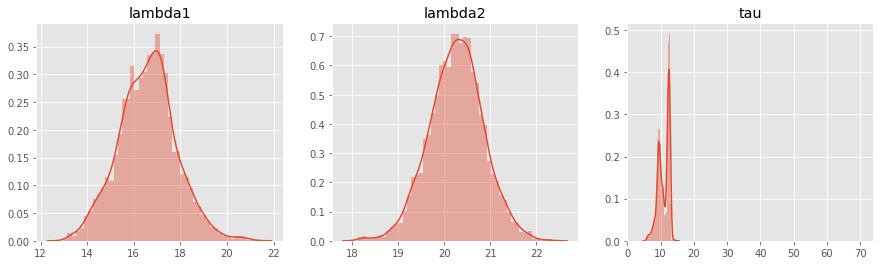

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15, 4))
sns.distplot(lambda1_, ax=axs[0]); axs[0].set_title('lambda1')
sns.distplot(lambda2_, ax=axs[1]); axs[1].set_title('lambda2')
sns.distplot(tau_, ax=axs[2]); axs[2].set_title('tau'); axs[2].set_xlim([0,n_data])